In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../src/')
import dataset_prep

Import de la base de données

In [3]:
selected_columns = [
"nb_packets_sent",
"distance",
"distRealSR1",
"pos_y_rec_f",
"pos_y_rec",
"pos_x_rec_f",
"pos_x_rec",
"pos_x_send",
"pos_y_send",
"spd_x_send",
"spd_y_send",
"sendTime",
"receiver",
"sender",
"label"
]

In [4]:
df = dataset_prep.import_dataset('../../data/0709/data0709.csv', selected_columns)

Nombre de lignes avant nettoyage :  1048575
Nombre de lignes après nettoyage :  1038446


Analyse et vérification des données

In [5]:
senders = np.unique(df["sender"].values)
senders

array([   9,   15,   21, ..., 6687, 6693, 6699])

In [5]:
print(len(senders))

1116


In [6]:
# Copie de la bdd pour récuperer les colonnes sans impacter la vraie base de données

data_copy = df.copy()
data_copy = data_copy.drop(["label"], axis=1)

columns = data_copy.columns
columns

Index(['sendTime', 'sender', 'receiver', 'pos_x_send', 'pos_y_send',
       'spd_x_send', 'spd_y_send', 'pos_x_rec', 'pos_y_rec', 'pos_x_rec_f',
       'pos_y_rec_f', 'nb_packets_sent', 'distRealSR1', 'distance'],
      dtype='object')

Amélioration à faire :

Séléctionner seulement les sender avec value_counts > 20

Séparation de la base de données : diviser pour régner

In [7]:
# /!\ attention à bien utiliser la base de données rangée par sender pour limiter la perte de données
# Indice égal à 0, 1 ou 2
# Célia = 0
# Chléo = 1
# Thomas = 2

def split_data_in_3(df, indice):
    # Division de la bdd en 3
    split_data = np.array_split(df,3)

    # Division en plusieurs sous-bdd pour diminuer le temps de calcul par exécution
    #divided_data = np.array_split(split_data[indice],50)

    return split_data

/!\ à bien changer l'indice !!

In [8]:
divided_dataframes = split_data_in_3(df.sort_values("sender"),0)

In [9]:
len(divided_dataframes)

3

Création des séquences

In [8]:
def sequence_creation(df):
    senders_sequences = np.array()
    senders_label = np.array
    for sender in senders:
        sender_data_sorted = df.loc[df['sender'] == sender].sort_values("sendTime")
        sender_data_sorted = sender_data_sorted.drop(["label","sender"], axis=1)
        sequence_array = np.array

        length = sender_data_sorted.shape[0]
        slide = 10
        start = 0
        end = 20

        # On récupère la valeur du label pour ce sender
        label = df.loc[df['sender'] == sender]['label'].tolist()[0]
        if (length > 20):
            senders_label.append(label)

        # On vérifie qu'il est possible de faire une séquence de taille 20
        while length >= 20:
            # Extraction par tranche de 20 avec une inter de 10
            sequence = sender_data_sorted[start:end]

            # Labels correspondant
            #labels =  pd.Series.tolist(sequence["label"])

            # On transforme les 13 en 1, cette formule marche toujours si on met d'autres types d'attaques
            #labels[:] = [x if x == 0 else 1 for x in labels]

            # Attribution des tableaux numpy
            sequence_array = np.append(sequence_array, np.array(sequence.values, dtype=object))
            #label_array.append(labels)

            # Mise à jour des variables
            start += slide
            end += slide
            length -= 10
        
        if len(sequence_array)>0:
            senders_sequences = np.append(senders_sequences, np.array(sequence_array, dtype=object))

    
    return senders_sequences, senders_label

In [9]:
def flat_sequence_creation(df):
    senders_sequences = []
    senders_label = []

    for sender in senders:
        # Données d'un seul sender rangée en fonction de l'heure d'envoi
        sender_data_sorted = df.loc[df['sender'] == sender].sort_values("sendTime")

        # On récupère la valeur du label pour ce sender
        """ On remplasse toute les valeur !=0 en 1 """
        if sender_data_sorted['label'].tolist()[0] != 0 :
            label=1
        else :
            label = sender_data_sorted['label'].tolist()[0]
        #On supprime les colonnes label et sender
        sender_data_sorted = sender_data_sorted.drop(["label","sender"], axis=1)
        
        #sequence_array = []

        length = sender_data_sorted.shape[0]
        slide = 10
        start = 0
        end = 20

        # On vérifie qu'il est possible de faire une séquence de taille 20
        while length > 20:
            # Extraction par tranche de 20 avec une inter de 10
            sequence = sender_data_sorted[start:end]

            # Labels correspondant
            #labels =  pd.Series.tolist(sequence["label"])

            # On transforme les 13 en 1, cette formule marche toujours si on met d'autres types d'attaques
            #labels[:] = [x if x == 0 else 1 for x in labels]

            # Attribution des tableaux numpy
            senders_sequences.append(np.array(sequence.values.tolist(), dtype=np.float32))
            senders_label.append(label)

            # Mise à jour des variables
            start += slide
            end += slide
            length -= 10

    return senders_sequences, senders_label

/!\ à bien changer l'indice !!

In [10]:
sorted_dataset = df.sort_values("sender")

In [12]:
sequence_test, label_test = flat_sequence_creation(sorted_dataset)
#label_test

sequence_test, label_test = sequence_creation(df)

In [18]:
len(sequence_test)

102132

# Initialisation des données

In [13]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers, applications, utils, models, optimizers, Input, callbacks
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

2023-02-01 18:17:12.602881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-01 18:17:12.602912: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [14]:
# Transformation en array numpy
X = np.array(sequence_test)
y = np.array(label_test, dtype=np.float32)

In [ ]:
#X = X[:100]
#y = y[:100]

In [15]:
# Séparation en données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [16]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_train :  (91918, 20, 13)
y_train :  (91918,)
X_test :  (10214, 20, 13)
y_test :  (10214,)


In [17]:
y_train

array([1., 1., 0., ..., 1., 0., 1.], dtype=float32)

# Modèle dense simple

In [22]:
# TODO amélioration du model dense avec du dropout ? 
simple_model = keras.Sequential([
    layers.Dense(128,input_shape=(20, 13), activation='relu'),
    #layers.BatchNormalization(), # les batchNormalization fond baisser l'accuracy 
    layers.Dense(256, activation='relu'),
    #layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear') # avec relu on perd un peu d'accuracy
])

2023-02-01 13:51:03.206784: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-01 13:51:03.206817: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (student-laptop): /proc/driver/nvidia/version does not exist
2023-02-01 13:51:03.207356: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
print("INPUT")
[print(i.shape, i.dtype) for i in simple_model.inputs]
print("OUTPUT")
[print(o.shape, o.dtype) for o in simple_model.outputs]
print("LAYERS")
[print(l.name, l.input_shape, l.dtype) for l in simple_model.layers]

INPUT
(None, 20, 13) <dtype: 'float32'>
OUTPUT
(None, 20, 1) <dtype: 'float32'>
LAYERS
dense (None, 20, 13) float32
dense_1 (None, 20, 128) float32
dense_2 (None, 20, 256) float32
dense_3 (None, 20, 64) float32


[None, None, None, None]

In [24]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
opt = keras.optimizers.SGD(learning_rate=0.01)
simple_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')

In [25]:
history = simple_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.3, callbacks=[callback])

Epoch 1/20


2023-02-01 13:51:11.533153: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 66915680 exceeds 10% of free system memory.


500/503 [============================>.] - ETA: 0s - loss: 8.5787 - accuracy: 0.4438

2023-02-01 13:51:18.343339: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28679040 exceeds 10% of free system memory.


503/503 [==============================] - 8s 14ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435
Epoch 2/20
503/503 [==============================] - 8s 15ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435
Epoch 3/20
503/503 [==============================] - 8s 16ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435
Epoch 4/20
503/503 [==============================] - 7s 13ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435
Epoch 5/20
503/503 [==============================] - 7s 13ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435
Epoch 6/20
503/503 [==============================] - 7s 13ms/step - loss: 8.5796 - accuracy: 0.4438 - val_loss: 8.5840 - val_accuracy: 0.4435


<AxesSubplot:>

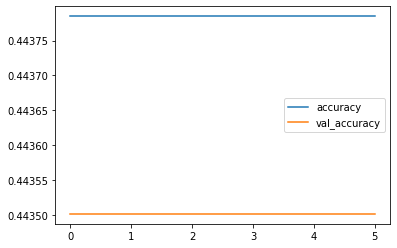

In [26]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

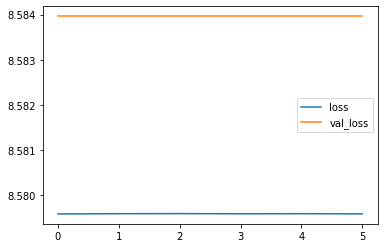

In [27]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [28]:
y_pred=simple_model.predict(X_test)
y_pred

array([[[-2675.2456],
        [-2594.6848],
        [-2536.4214],
        ...,
        [-2671.0312],
        [-2673.9482],
        [-2675.3208]],

       [[-2535.6345],
        [-2558.4849],
        [-2514.2288],
        ...,
        [-2540.9268],
        [-2514.7249],
        [-2518.0361]],

       [[-2317.2705],
        [-2313.675 ],
        [-2316.7458],
        ...,
        [-2313.2676],
        [-2317.3103],
        [-2313.7146]],

       ...,

       [[-2850.0059],
        [-2889.824 ],
        [-2872.5151],
        ...,
        [-2881.8242],
        [-2888.7388],
        [-2876.1653]],

       [[-2607.457 ],
        [-2608.5615],
        [-2554.9438],
        ...,
        [-2603.5146],
        [-2607.5068],
        [-2549.032 ]],

       [[-2176.254 ],
        [-2182.1982],
        [-2185.5642],
        ...,
        [-2134.818 ],
        [-2118.3774],
        [-2165.62  ]]], dtype=float32)

In [29]:
eval=simple_model.evaluate(X_test, y_test)
eval

320/320 [==============================] - 1s 3ms/step - loss: 8.7198 - accuracy: 0.4347


[8.719759941101074, 0.4346974790096283]

# RNN

In [30]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    '''
    hidden_units : nombre de neurones dans la couche SimpleRNN
    dense_units : nombre de neurones dans la couche Dense
    activation : liste des deux fonctions d'activation
    '''
    opt = keras.optimizers.SGD(learning_rate=0.01)
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, return_sequences=True, activation=activation[0]))
    model.add(SimpleRNN(32, activation=activation[0]))
    model.add(keras.layers.BatchNormalization())
    model.add(Dense(64, activation=activation[1]))
    model.add(Dense(units=dense_units, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')
    return model

#demo_model = create_RNN(2, 1, (3,1), activation=['linear', 'linear'])

rnn_model = create_RNN(32, 1, (20, 13), activation=['relu', 'relu'])
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [31]:
history = rnn_model.fit(X_train, y_train, epochs=20, batch_size=128, validation_split=0.3, callbacks=[callback])

Epoch 1/20


2023-02-01 14:02:22.859087: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 66915680 exceeds 10% of free system memory.


498/503 [============================>.] - ETA: 0s - loss: 0.4202 - accuracy: 0.8221

2023-02-01 14:02:28.860898: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 28679040 exceeds 10% of free system memory.


503/503 [==============================] - 7s 11ms/step - loss: 0.4198 - accuracy: 0.8221 - val_loss: 0.3501 - val_accuracy: 0.8445
Epoch 2/20
503/503 [==============================] - 5s 11ms/step - loss: 0.3368 - accuracy: 0.8514 - val_loss: 0.8098 - val_accuracy: 0.6363
Epoch 3/20
503/503 [==============================] - 6s 11ms/step - loss: 0.3346 - accuracy: 0.8521 - val_loss: 0.3379 - val_accuracy: 0.8465
Epoch 4/20
503/503 [==============================] - 5s 11ms/step - loss: 0.3296 - accuracy: 0.8526 - val_loss: 0.4370 - val_accuracy: 0.7911
Epoch 5/20
503/503 [==============================] - 5s 11ms/step - loss: 0.3272 - accuracy: 0.8531 - val_loss: 0.3326 - val_accuracy: 0.8497
Epoch 6/20
503/503 [==============================] - 6s 11ms/step - loss: 0.3259 - accuracy: 0.8545 - val_loss: 0.3301 - val_accuracy: 0.8478
Epoch 7/20
503/503 [==============================] - 6s 11ms/step - loss: 0.3239 - accuracy: 0.8565 - val_loss: 0.3863 - val_accuracy: 0.8265
Epoch 8/20

<AxesSubplot:>

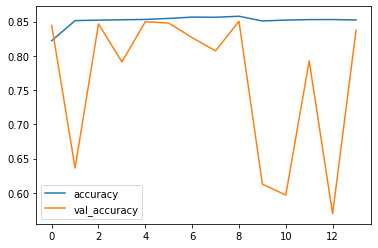

In [32]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

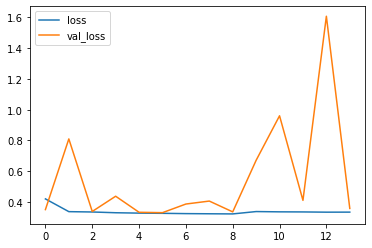

In [33]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [34]:
y_pred=rnn_model.predict(X_test)
y_pred

array([[0.0814237 ],
       [0.25599977],
       [0.99995077],
       ...,
       [0.11677942],
       [0.6047377 ],
       [0.9872718 ]], dtype=float32)

In [35]:
# arrondir les prédictions avant de les evalués
y_pred = [0 if x < 0.5 else 1 for x in y_pred] 
y_pred
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.87      0.83      4440
         1.0       0.89      0.83      0.86      5774

    accuracy                           0.85     10214
   macro avg       0.85      0.85      0.85     10214
weighted avg       0.85      0.85      0.85     10214



In [36]:
eval=rnn_model.evaluate(X_test, y_test)
eval

320/320 [==============================] - 1s 3ms/step - loss: 0.3330 - accuracy: 0.8488


[0.332971453666687, 0.8488349318504333]

# Test LSTM

In [113]:
lstm_model = keras.Sequential([
    layers.Dense(32, input_shape=(20,13), activation='relu'),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(128),
    #layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [114]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
opt = keras.optimizers.SGD(learning_rate=0.01)
lstm_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')

In [115]:
lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 20, 32)            448       
                                                                 
 lstm_19 (LSTM)              (None, 20, 128)           82432     
                                                                 
 lstm_20 (LSTM)              (None, 128)               131584    
                                                                 
 dense_55 (Dense)            (None, 64)                8256      
                                                                 
 dense_56 (Dense)            (None, 1)                 65        
                                                                 
Total params: 222,785
Trainable params: 222,785
Non-trainable params: 0
_________________________________________________________________


In [116]:
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.3, callbacks=[callback])

Epoch 1/20
2011/2011 [==============================] - 133s 63ms/step - loss: 0.6867 - accuracy: 0.5555 - val_loss: 0.6862 - val_accuracy: 0.5565
Epoch 2/20
2011/2011 [==============================] - 128s 64ms/step - loss: 0.6867 - accuracy: 0.5562 - val_loss: 0.6857 - val_accuracy: 0.5565
Epoch 3/20
2011/2011 [==============================] - 123s 61ms/step - loss: 0.6859 - accuracy: 0.5563 - val_loss: 0.6909 - val_accuracy: 0.5565
Epoch 4/20
2011/2011 [==============================] - 128s 64ms/step - loss: 0.6852 - accuracy: 0.5562 - val_loss: 0.6841 - val_accuracy: 0.5565
Epoch 5/20
2011/2011 [==============================] - 126s 63ms/step - loss: 0.6844 - accuracy: 0.5562 - val_loss: 0.6839 - val_accuracy: 0.5565
Epoch 6/20
2011/2011 [==============================] - 101s 50ms/step - loss: 0.6837 - accuracy: 0.5562 - val_loss: 0.6834 - val_accuracy: 0.5565


<AxesSubplot:>

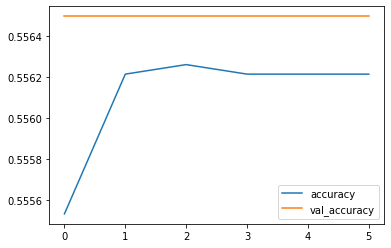

In [117]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

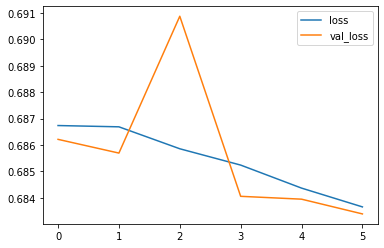

In [121]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [119]:
y_pred=lstm_model.predict(X_test)
y_pred

array([[0.54696834],
       [0.54696834],
       [0.54696834],
       ...,
       [0.54696834],
       [0.54696834],
       [0.54696834]], dtype=float32)

In [120]:
eval=lstm_model.evaluate(X_test, y_test)
eval

320/320 [==============================] - 3s 9ms/step - loss: 0.6846 - accuracy: 0.5653


[0.6846228241920471, 0.5653025507926941]

# Mélange SimpleRNN et LSTM

In [53]:
lstm_rnn_model = keras.Sequential([
    layers.Dense(32,input_shape=(20,13), activation='relu'),
    layers.LSTM(128, return_sequences=True, activation='relu'), # return_sequences à True pour que la sortie soit de dimension 3
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.SimpleRNN(64,activation='relu', return_sequences=True),
    layers.SimpleRNN(32,activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
opt = keras.optimizers.SGD(learning_rate=0.01)
lstm_rnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics='accuracy')

In [ ]:
history = lstm_rnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.3, callbacks=[callback])

<AxesSubplot:>

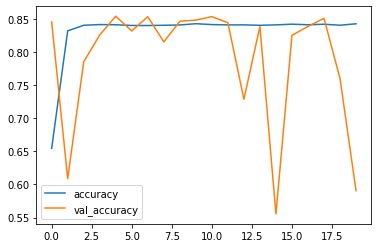

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

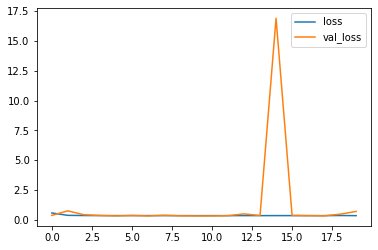

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot()

In [ ]:
y_pred=lstm_rnn_model.predict(X_test)
y_pred

array([[0.9794315 ],
       [0.56563175],
       [0.5521127 ],
       ...,
       [0.41327995],
       [0.9999872 ],
       [0.7330741 ]], dtype=float32)

In [ ]:
eval=lstm_rnn_model.evaluate(X_test, y_test)
eval

320/320 [==============================] - 2s 6ms/step - loss: 0.7070 - accuracy: 0.5944


[0.7070026397705078, 0.594380259513855]